<a href="https://colab.research.google.com/github/anhvt00/NeuroAI-2024/blob/main/TA_W1D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/student/W1D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D1_Generalization/student/W1D1_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Generalization in AI

**Week 1, Day 1: Generalization**

**By Neuromatch Academy**

__Content creators:__ Samuele Bolotta & Patrick Mineault

__Content reviewers:__ Samuele Bolotta, Lily Chamakura, RyeongKyung Yoon, Yizhou Chen, Ruiyi Zhang, Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 75 minutes*

This tutorial will introduce you to generalization in the context of modern AI systems. We'll look at a particular system trained for handwriting recognition–TrOCR. We'll review what makes that model tick–the transformer architecture–and explore what goes on into training and finetuning large-scale models. We'll look at how augmentations can bake in tolerance to certain transformations like scaling and cropping.

Our learning objectives for today are:

1. Identify and articulate common objectives pursued by developers of operational AI systems, such as:

- OOD robustness; Latency; Size, Weight, Power, and Cost (SWaP-C)
- Explainability and understanding

2. Explain at least three strategies for enhancing the generalization capabilities of AI systems, including the contemporary trend of training generic large-scale models on extensive datasets, commonly referred to as the ["bitter lesson."]((http://www.incompleteideas.net/IncIdeas/BitterLesson.html))

3. Gain practical experience with the fundamentals of deep learning and PyTorch.

**Important note**: this tutorial leverages GPU acceleration. Using a GPU runtime in colab will make the the tutorial run 10x faster.

Let's get started!

In [124]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "79523"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup



In [125]:
# @title Install and import feedback gadget

!pip install vibecheck Pillow matplotlib torch torchvision transformers gradio protobuf sentencepiece gradio torchmetrics --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W1D1_T1"

In [126]:
# @title Import dependencies

# Standard Libraries for file and operating system operations, security, and web requests
import os
import functools
import hashlib
import requests
import logging
import io
import re
import time

# Core python data science and image processing libraries
import numpy as np
from PIL import Image as IMG
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
import tqdm

# Deep Learning and model specific libraries
import torch
import torchmetrics.functional.text as fm
import transformers
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Utility and interface libraries
import gradio as gr
from IPython.display import IFrame, display, Image
import sentencepiece
import zipfile
import pandas as pd


device = "cuda" if torch.cuda.is_available() else "cpu"

In [127]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [128]:
# @title Plotting functions

def display_image(image_path):
    """Display an image from a given file path.

    Inputs:
    - image_path (str): The path to the image file.
    """
    # Open the image
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()

def display_transformed_images(image, transformations):
    """
    Apply a list of transformations to an image and display them.

    Inputs:
    - image (Tensor): The input image as a tensor.
    - transformations (list): A list of torchvision transformations to apply.
    """
    # Convert tensor image to PIL Image for display
    pil_image = transforms.ToPILImage()(image)

    fig, axs = plt.subplots(len(transformations) + 1, 1, figsize=(5, 15))
    axs[0].imshow(pil_image, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    for i, transform in enumerate(transformations):
        # Apply transformation if it's not the placeholder
        if transform != "Custom ElasticTransform Placeholder":
            transformed_image = transform(image)
            # Convert transformed tensor image to PIL Image for display
            display_image = transforms.ToPILImage()(transformed_image)
            axs[i+1].imshow(display_image, cmap='gray')
            axs[i+1].set_title(transform.__class__.__name__)
            axs[i+1].axis('off')
        else:
            axs[i+1].text(0.5, 0.5, 'ElasticTransform Placeholder', ha='center')
            axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_original_and_transformed_images(original_tensor, transformed_tensor):
    """
    Display the original and transformed images side by side.

    Inputs:
    - original_tensor (Tensor): The original image as a tensor.
    - transformed_tensor (Tensor): The transformed image as a tensor.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    original_image = original_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Display transformed image
    transformed_image = transformed_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[1].imshow(transformed_image, cmap='gray')
    axs[1].set_title('Transformed')
    axs[1].axis('off')

    plt.show()

def display_generated_images(generator):
    """
    Display images generated from strings.

    Inputs:
    - generator (GeneratorFromStrings): A generator that produces images from strings.
    """
    plt.figure(figsize=(15, 3))
    for i, (text_img, lbl) in enumerate(generator, 1):
        ax = plt.subplot(1, len(generator.strings) * generator.count // len(generator.strings), i)
        plt.imshow(text_img)
        plt.title(f"Example {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Function to generate an image with text
def generate_image(text, font_path, space_width=2, skewing_angle=8):
    """Generate an image with text.

    Args:
        text (str): Text to be rendered in the image.
        font_path (str): Path to the font file.
        space_width (int): Space width between characters.
        skewing_angle (int): Angle to skew the text image.
    """
    image_size = (350, 50)
    background_color = (255, 255, 255)
    speckle_threshold = 0.05
    speckle_color = (200, 200, 200)
    background = np.random.rand(image_size[1], image_size[0], 1) * 64 + 191
    background = np.tile(background, [1, 1, 4])
    background[:, :, -1] = 255
    image = IMG.fromarray(background.astype('uint8'), 'RGBA')
    image2 = IMG.new('RGBA', image_size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(image2)
    font = ImageFont.truetype(font_path, size=36)
    text_size = draw.textlength(text, font=font)
    text_position = ((image_size[0] - text_size) // 2, (image_size[1] - font.size) // 2)
    draw.text(text_position, text, font=font, fill=(0, 0, 0), spacing=space_width)
    image2 = image2.rotate(skewing_angle)
    image.paste(image2, mask=image2)
    return image

# Function to generate images for multiple strings
def image_generator(strings, font_path, space_width=2, skewing_angle=8):
    """Generate images for multiple strings.

    Args:
        strings (list): List of strings to generate images for.
        font_path (str): Path to the font file.
        space_width (int): Space width between characters.
        skewing_angle (int): Angle to skew the text image.
    """
    for text in strings:
        yield generate_image(text, font_path, space_width, skewing_angle)

In [129]:
# @title Data retrieval

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    Verifies the integrity of the file using an MD5 checksum.

    Args:
    - fname (str): The local filename/path to save the downloaded file.
    - url (str): The URL from which to download the file.
    - expected_md5 (str): The expected MD5 checksum to verify the integrity of the downloaded data.
    """
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
            r.raise_for_status()  # Raises an HTTPError for bad responses
        except (requests.ConnectionError, requests.HTTPError) as e:
            print(f"!!! Failed to download {fname} due to: {str(e)} !!!")
            return
        if hashlib.md5(r.content).hexdigest() == expected_md5:
            with open(fname, "wb") as fid:
                fid.write(r.content)
            print(f"{fname} has been downloaded successfully.")
        else:
            print(f"!!! Data download appears corrupted, {hashlib.md5(r.content).hexdigest()} !!!")

def extract_zip(zip_fname, folder='.'):
    """
    Extracts a ZIP file to the specified folder.

    Args:
    - zip_fname (str): The filename/path of the ZIP file to be extracted.
    - folder (str): Destination folder where the ZIP contents will be extracted.
    """
    if zipfile.is_zipfile(zip_fname):
        with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
            zip_ref.extractall(folder)
            print(f"Extracted {zip_fname} to {folder}.")
    else:
        print(f"Skipped extraction for {zip_fname} as it is not a zip file.")

# Define the list of files to download, including both ZIP files and other file types
file_info = [
    ("Dancing_Script.zip", "https://osf.io/32yed/download", "d59bd3201b58a37d0d3b4cd0b0ec7400", '.'),
    ("lines.zip", "https://osf.io/8a753/download", "6815ed3987f8eb2fd3bc7678c11f2e9e", 'lines'),
    ("transcripts.csv", "https://osf.io/9hgr8/download", "d81d9ade10db55603cc893345debfaa2", None),
    ("neuroai_hello_world.png", "https://osf.io/zg4w5/download", "f08b81e47f2fe66b5f25b2ccc204c780", None),  # New image file
    ("sample0.png", "https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/sample_0.png?raw=true", '920ae567f707bfee0be29dc854f804ed', None),
    ("sample1.png", "https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/sample_1.png?raw=true", 'cd28623a829b40d0a1dd8c0f17e9ebd7', None),
    ("sample2.png", "https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/sample_2.png?raw=true", 'c189c09abf989eac4e1a8d493bd362d7', None),
    ("sample3.png", "https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/sample_3.png?raw=true", 'dcffc678266952f18af1fc1242127e98', None)
]

import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()):
    # Process the downloads and extractions
    for fname, url, expected_md5, folder in file_info:
        download_file(fname, url, expected_md5)
        if folder is not None:
            extract_zip(fname, folder)

In [130]:
# @title Video 1: Overview

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'PgA7wfi2eDo'), ('Bilibili', 'BV1Bm421L7zB')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [131]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_overview_video")

---
# Section 1: Motivation: building a handwriting recognition app with AI

Let’s put ourselves into the mindset of an AI developer who wants to build a note app featuring handwriting recognition.

![Picture which shows the goal of the day.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/W1D1_goal.png?raw=true)

Our intrepid developer doesn't want to start from scratch, so searches for a pretrained model. They find a suitable model hosted on HuggingFace, the largest repository of pretrained natural language and vision models. [TrOCR](https://huggingface.co/docs/transformers/en/model_doc/trocr) is a Transformer-based model that performs Optical Character Recognition and handwriting transcription. Several checkpoints are available, finetuned for different downstream applications like handwriting transcription and printed character recognition. Our relieved developer draws a deep sigh: they don't have to start from scratch.

![Picture which shows trocr architecture.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/trocr_architecture.png?raw=true)

In this tutorial, we'll look at the design considerations that go into training and deploying a model like TrOCR, what goes on inside the model's transformers, and how it achieves good or bad out-of-distribution generalization. While the NeuroAI course as a whole will explore new ideas at the frontier of neuroscience and AI, we'll first want to understand one of the bread-and-butter building blocks used in industrial AI: the transformer.

Let's try out this model ourselves!

## Interactive demo 1: TrOCR

We load a pretrained TrOCR checkpoint from HuggingFace. The `transformers` package from HuggingFace allows us to download a PyTorch model definition and a preprocessing class, and to load a pretrained checkpoint in just a few lines of code.

In [132]:
# Load the pre-trained TrOCR model and processor
with contextlib.redirect_stdout(io.StringIO()):
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
    model.to(device=device)
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten", use_fast=False)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We now write a callback function that calls the preloaded model to decode a particular image.

In [133]:
# Define the function to recognize text from an image
def recognize_text(processor, model, image):
    """
    This function takes an image as input and uses a pre-trained language model to generate text from the image.

    Inputs:
    - processor: The processor to use
    - model: The model to use
    - image (PIL Image or Tensor): The input image containing text to be recognized.

    Outputs:
    - text (str): The recognized text extracted from the input image.
    """
    print(image)
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values.to(device))
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

We build a simple interface in `gradio` to try out the model interactively. Go ahead and try some example text to see how it works. You can use images from the internet, or scan your own handwriting. Just make sure that the text fits on one line.

In [134]:
import gradio as gr
import functools

with gr.Blocks() as demo:
    gr.HTML("<h1>Interactive demo: TrOCR</h1>")
    gr.Markdown("Upload a single image or click one of the examples to try this.")

    # Define the examples
    examples = [
        'neuroai_hello_world.png',
        'sample1.png',
        'sample2.png',
        'sample3.png',
    ]

    # Create the image input component
    image_input = gr.Image(type="pil", label="Upload Image")

    # Create the example gallery
    example_gallery = gr.Examples(
        examples,
        image_input,
    )

    # Create the submit button
    with gr.Row():
        submit_button = gr.Button("Recognize Text", scale=1)

        # Create the text output component
        text_output = gr.Textbox(label="Recognized Text", scale=2)

    # Define the event listeners
    submit_button.click(
        fn=functools.partial(recognize_text, processor, model),
        inputs=image_input,
        outputs=text_output
    )

# Launch the interface
demo.launch(height=650)
_

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://761f477c2392df1678.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [135]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Interactive_Demo_1")

### Discussion point 1

How effective is the model's performance? Does it exhibit generalization beyond its training vocabulary?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D1_Generalization/solutions/W1D1_Tutorial1_Solution_21c15345.py)



In [136]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_1")

In [137]:
# @title Video 2: OOD Generalization

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'pPljFAsgzA8'), ('Bilibili', 'BV1jx4y1b7Xh')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [138]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_ood_generalization")

---
# Section 2: Measuring out-of-distribution generalization in TrOCR

How well does TrOCR work in practice? Our developer needs to know!

Something you will see a lot of in machine learning papers are tables filled with benchmarks. The tables in the [TrOCR official paper](https://arxiv.org/abs/2109.10282) include measures of performance on different benchmark datasets, including IAM, a handwriting database assembled in 1999. The base and large model variants (334M and 558M parameters) display **character error rates (CER) of 3.42 and 2.89, respectively**. That means it gets 97% of characters correct.

"Wow!", our developer thinks, "That's probably good enough for my notes app! Guess I can go ahead and deploy it".

## Think! 1

What are some reasons why the character error rate measured on IAM might be too optimistic?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Think_1")

## Coding activity 1: Measuring out-of-distribution generalization

Our developer reads through the fine print in the paper and realizes that the TrOCR is both *trained* on IAM and *tested* on IAM, on a different set of subjects. To be clear, the train and test splits are *distinct*; but samples come from the same underlying distribution. Our developer realizes that the reported error rates might be too optimistic:

* IAM was recorded on a tablet. Our developer wants to be able to recognize lines of text handwritten on paper.
* IAM is 25 years old. Maybe people write differently now compared to in the past. Do they even write in cursive anymore?
* The sentences in IAM are based on a widely published corpus. Maybe TrOCR has memorized that corpus.

The more the developer thinks about it, the more they realize that the paper is really estimating *in-distribution generalization*. However, what they care about is how well the model will work when it's deployed *in the wild*, which is closer to **out-of-distribution generalization**.

In this coding activity, you'll measure out-of-distribution generalization on a small subset of the CVL database:

> Kleber, F., Fiel, S., Diem, M., & Sablatnig, R. (2018). [CVL Database - An Off-line Database for Writer Retrieval, Writer Identification and Word Spotting [Data set]. Zenodo.](https://doi.org/10.5281/zenodo.1492267)

Let's first have a look at this new out-of-distribution dataset.

In [ ]:
# @title Run this cell to visualize dataset.
def get_images_and_transcripts(df, subject):
    df_ = df[df.subject == subject]
    transcripts = df_.transcript.values.tolist()

    # Load the corresponding images
    images = []
    for _, row in df_.iterrows():
        images.append(IMG.open(row.filename))

    return images, transcripts

def visualize_images_and_transcripts(images, transcripts):
    for img in images:
        display(img)

    for transcript in transcripts:
        print(transcript)

df = pd.read_csv('transcripts.csv')
df['filename'] = df.apply(lambda x: f"lines/{x.subject:04}-{x.line}.jpg", axis=1)
df

This is a small test set with 94 lines sampled from 10 different subjects. Let's have a look at the data from subject 54.

In [ ]:
images, true_transcripts = get_images_and_transcripts(df, 52)
visualize_images_and_transcripts(images, true_transcripts)

The text is transcribed from a passage in the novel [Flatland by Edwin Abbott Abbott](https://en.wikipedia.org/wiki/Flatland). The data is conceptually similar to the IAM database, with single isolated lines of text, but it was recorded on paper less than 10 years ago, so it should be more representative of how people write on paper today.

How well does the model recognize the text? Run this cell to find out.

In [ ]:
def transcribe_images(all_images, model, processor):
    """
    Transcribe a batch of images using an OCR model.

    Args:
        all_images: a list of PIL images.
        model: the model to do image-to-token ids
        processor: the processor which maps token ids to text

    Returns:
        a list of the transcribed text.
    """
    pixel_values = processor(images=all_images, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values.to(device))
    decoded_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_text

transcribed_text = transcribe_images(images, model, processor)
print(transcribed_text)

### Code exercise 1.1: Calculate CER and WER

The model is not perfect but it performs far better than chance. Let's measure the character and the word error rates on this subject's data.

The character error rate between a reference string `ref` and a predicted string `pred` is defined as:

$$CharErrorRate = \frac{S+D+I}{N}$$

* $N$ is the number of characters in the reference string
* $S$ is the number of substitutions to transform the predicted string to the reference string
* $D$ is the number of deletions to transform the predicted string to the reference string
* $I$ is the number of insertions to transform the predicted string to the reference string

For example, to transform `3nanas` to `banana`, we'd need to replace `3` with `b`, insert an `a`, and delete the `s`. The character error rate would $(1+1+1)/6=0.5$. The word error rate is defined similarly, but at the single word rather than the character level.

Thankfully, we can use a library function to help us out! `torchmetrics.functional.text.char_error_rate(preds, refs)` calculates the average character error rate over a list of predictions and references. `torchmetrics.functional.text.word_error_rate(preds, refs)` does the same for the average word error rate.

Fill in missing code to measure character and word error rates on this dataset.

In [ ]:
import torchmetrics.functional.text as fm

def clean_string(input_string):
    """
    Clean string prior to comparison

    Args:
        input_string (str): the input string

    Returns:
        (str) a cleaned string, lowercase, alphabetical characters only, no double spaces
    """

    # Convert all characters to lowercase
    lowercase_string = input_string.lower()

    # Remove non-alphabetic characters
    alpha_string = re.sub(r'[^a-z\s]', '', lowercase_string)

    # Remove double spaces and start and end spaces
    return re.sub(r'\s+', ' ', alpha_string).strip()


def calculate_mismatch(estimated_text, reference_text):
    """
    Calculate mismatch (character and word error rates) between estimated and true text.

    Args:
        estimated_text: a list of strings
        reference_text: a list of strings

    Returns:
        A tuple, (CER and WER)
    """
    # Lowercase the text and remove special characters for the comparison
    estimated_text = [clean_string(x) for x in estimated_text]
    reference_text = [clean_string(x) for x in reference_text]

    ############################################################
    # Fill in this code to calculate character error rate and word error rate.
    # Hint: have a look at the torchmetrics documentation for the proper
    # metrics.
    #
    # https://lightning.ai/docs/torchmetrics/stable/
    # raise NotImplementedError("Student has to fill in these lines")
    ############################################################

    # Calculate the character error rate and word error rates. They should be
    # raw floats, not tensors.
    cer = fm.char_error_rate(estimated_text, reference_text)
    wer = fm.word_error_rate(estimated_text, reference_text)
    return (cer, wer)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D1_Generalization/solutions/W1D1_Tutorial1_Solution_4d36b048.py)



In [ ]:
cer, wer = calculate_mismatch(transcribed_text, true_transcripts)
# assert isinstance(cer, float)
cer, wer

For this particular subject, the character error rate is 3.3%, while the word error rate is 10%. Not bad, and in line with the results in the paper.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Code_Exercise_1.1")

### Code exercise 1.2: Calculate CER and WER across all subjects

Let's measure the same metric, this time across all subjects. Note: If you run this code on the CPU, it might take around 5 minutes to complete.

In [ ]:
def calculate_all_mismatch(df, model, processor):
    """
    Calculate CER and WER for all subjects in a dataset

    Args:
        df: a dataframe containing information about images and transcripts
        model: an image-to-text model
        processor: a processor object

    Returns:
        a list of dictionaries containing a per-subject breakdown of the
        results
    """
    subjects = df.subject.unique().tolist()

    results = []

    # Calculate CER and WER for all subjects
    for subject in tqdm.tqdm(subjects):
        ############################################################
        # Fill in the section to calculate the cer and wer for a
        # single subject. Look up at other sections to see how it's
        # done.
        # raise NotImplementedError("Student exercise")
        ############################################################

        # Load images and labels for a given subject
        images, true_transcripts = get_images_and_transcripts(df, subject)

        # Transcribe the images to text
        transcribed_text = transcribe_images(images, model, processor)

        # Calculate the CER and WER
        cer, wer = calculate_mismatch(transcribed_text, true_transcripts)

        results.append({
            'subject': subject,
            'cer': cer,
            'wer': wer,
        })
    return results

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D1_Generalization/solutions/W1D1_Tutorial1_Solution_cbbb272d.py)



In [ ]:
results = calculate_all_mismatch(df, model, processor)
df_results = pd.DataFrame(results)
df_results

Not all subjects are as easy to transcribe as subject 52! Let's check out subject 57, who has high CER and WER.

In [ ]:
print("A subject that's harder to read")
images, true_transcripts = get_images_and_transcripts(df, 57)
visualize_images_and_transcripts(images, true_transcripts)

Indeed, this text seems harder to read.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Code_Exercise_1.2")

### Code exercise 1.3: Measure OOD generalization

What we've done thus far is to measure the empirical loss–the character error rate–for each subject. The empirical loss is defined as:

$$R^e(\theta) = \mathbb{E}^e[ L(y, f(x, \theta)) ] $$

Here:

* The environment $e$ is the training distribution
* $R^e(\theta)$ is the empirical risk in an environment
* $\theta$ are the learned parameters of the TrOCR model
* $x$ is the conditioning data, that is, the images
* $f$ is the function approximated by the TrOCR model, which maps images to probabilities of certain tokens
* $L$ is the loss (or metric–not necessarily differentiable) for a single line of text, the character error rate (CER)
* $\mathbb{E}^e$ is the expectation taken over all the samples

A single environment $e$ corresponds to a single subject. The out-of-distribution generalization is instead given by:

$$R^{OOD} = \max_{e \in \mathcal{E}_{all}} R^e(\theta) $$

It's the worst-case empirical loss over the out-of-distribution environments ${e \in \mathcal{E}_{all}}$ we wish to deploy on. In other words, the character error rate for the subject with the most difficult-to-read handwriting.

Intuitively, our AI developer's vision of robustness might be: my note transcription app is robust and generalizes if it works well even when someone has illegible handwriting. The app is only as good as how well it works in the worst-case scenario. Let's measure that.

In [ ]:
def calculate_mean_max_cer(df_results):
    """
    Calculate the mean character-error-rate across subjects as
    well as the maximum (that is, the OOD risk).

    Args:
        df_results: a dataframe containing results

    Returns:
        A tuple, (mean_cer, max_cer)
    """
    ############################################################
    # Fill in the section to calculate the mean and max cer
    # across subjects.
    # raise NotImplementedError("Student exercise")
    ############################################################

    # Calculate the mean CER across test subjects.
    mean_subjects = df_results.cer.mean()

    # Calculate the max CER across test subjects.
    max_subjects = df_results.cer.max()
    return mean_subjects, max_subjects

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D1_Generalization/solutions/W1D1_Tutorial1_Solution_7cf70ea7.py)



In [ ]:
mean_subjects, max_subjects = calculate_mean_max_cer(df_results)
mean_subjects, max_subjects

We see that:

* when measured on this (admittedly small) out-of-distribution dataset, the average character error rate is about 5.8%, larger than the 3.4% reported for IAM
* the out-of-distribution character error rate is 12%

Whether that's good enough for our AI developer depends on the use case.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Code_Exercise_1.3")

## Discussion

Numbers in tables filled with benchmarks don't tell the whole story: often, we care about OOD robustness. Our developer benchmarked the TrOCR model for their use case and found a worst-case character error rate above 10%. Whether or not that's acceptable is a judgment call, and it's not the only metric the developer might care about. They might also need to meet other constraints:

- Memory, FLOPs, latency, cost of inference: the deployment environment might not be able to support very large-scale models because of memory or compute constraints, or those would run too slowly for the use case. Cloud inference might not be practical with limited internet access.
- SWaP-C: if the model is embodied in a physical device, the Size, Weight, Power and Cost of that device will ultimately be important. More powerful models can require bigger, heavier, more power-hungry hardware.
- Latency of development: a bespoke model developed from scratch might take a long time to develop; our busy developer might prefer to adopt a pretrained, sub-optimal architecture than using a custom architecture
- Cost of upkeep: machine learning systems can be notoriously difficult to keep running. Our developer might prefer to use a suboptimal system managed by somebody else rather than taking on the burden of dealing with the upkeep themselves.

Our intrepid developer wants to ship this app soon! They decide on a strategy: the model is good enough to get started. They'll deploy the model as is, but they'll have an option in the app to report errors. They'll then label *those* errors and fine-tune the model. Before that though, they want to understand what's inside the model.

In [ ]:
# @title Video 3: TrOCR

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'CFhBX4CL-88'), ('Bilibili', 'BV1iz421b7Qb')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_trocr")

---
# Section 3: Dissecting TrOCR

TrOCR (transformer-based optical character recognition) is a model that performs printed optical character recognition and handwriting transcription on the basis of two transformers. But what's inside of it?

![Picture which shows trocr architecture.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/trocr_architecture.png?raw=true)



TrOCR uses two transformers in an encoder-decoder architecture:

1. An encoder, a vision transformer (ViT), maps 16x16 patches of the image to individual tokens
2. A decoder, a text transformer, maps previously decoded text and the encoder's hidden state to the next token in the sequence to be decoded. This is known as causal language modeling.

## Section 3.1: A recap of transformers

[We covered transformers in W2D5 of the DL course](https://deeplearning.neuromatch.io/tutorials/W2D5_AttentionAndTransformers/student/W2D5_Tutorial1.html). Let's quickly recap them. Transformers are a class of deep learning architectures that have become dominant in natural language processing (NLP) since their introduction in the paper "Attention is All You Need" by Vaswani et al. in 2017. Their success in natural language processing has led to their application across other domains, including computer vision, which is the case with TrOCR.

![Picture which shows one layer transformer.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/transformer_one_layer.png?raw=true)



*Illustration from Alammar, J (2018). The Illustrated Transformer. Retrieved from https://jalammar.github.io/illustrated-transformer/*

Transformers are built on self-attention, allowing them to weigh the importance of different parts of the input data differently. This has proven useful for tasks that require an understanding of context, such as language translation, text summarization, and, as we will see, optical character recognition. Some key components of transformers are:

- Tokenization: the input sequence (e.g. sentence) is split into different components (e.g. word pieces). Each component, or token, is embedded into a fixed dimensional space. In natural language processing, tokenization is done via a lookup table: every word piece is mapped to a fixed-dimensional vector. [See W3D1 of the DL course for a refresher on tokenization](https://deeplearning.neuromatch.io/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/student/W3D1_Tutorial2.html?highlight=word2vec#tokenizers).

- Self-attention: A self-attention mechanism allows the tokens in the sequence to interact to form new representations. Specifically, queries and keys are derived from tokens; an inner product between queries and keys, followed by a softmax, forms the attention matrix. The attention matrix is multiplied by the value matrix to obtain a new representation.

- Positional encoding: Positional encoding is added to the input to give the model information about the position of each token within the sequence. Unlike RNNs or CNNs, transformers **do not process data in order–without position encoding, they are permutation invariant**. We'll dig deeper into what this implies in the section on the inductive biases of transformers.

- Layer Normalization and Residual Connections are used within the transformer architecture to stabilize the learning process and improve the model's ability to learn deep representations.

One of the key advantages of transformers over previous architectures is a high degree of parallelism, which allows one to train larger, more capable models. Let's inspect TrOCR's architecture.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Recap_Transformers")

## Section 3.2: The encoder

Let's dig in more specifically into the **encoder** inside of TrOCR. It's a visual transformer (ViT), an adaptation of transformers for problems in vision. It proceeds as follows:

1. It takes a raw image and resizes it to 384x384
2. It chops it up into 16x16 patches
3. It embeds each patch inside a fixed, 768-dimensional space, adding positional embeddings
4. It passes the patches through self-attention layers.
5. It ends up with one token for each patch, plus one for the class embedding, $577=(384/16)^2+1$.

Let's look at the structure of the encoder:

In [ ]:
model.encoder

### Code exercise 3.1: Understanding the inputs and outputs of the decoder

Let's make sure we understand how the encoder operates by giving it a sample input and checking that its output matches the expected shape.

In [187]:
def inspect_decoder(model):
    """
    Inspect decoder to verify that it processes inputs in the expected way.

    Args:
        model: the TrOCR model
    """
    ##################################################################
    # Feed the encoder an input and measure the output to understand
    # the role of the vision encoder.
    # raise NotImplementedError("Student exercise")
    #
    ##################################################################
    # Create an empty tensor (batch size of 1) to feed it to the encoder.
    # Remember that images should have 3 channels and have size 384x384
    # Recall that images are fed in pytorch with tensors of shape
    # batch x channels x height x width
    single_input = torch.zeros(1, 3, 384, 384).to(device)

    # Run the input through the encoder.
    output = model.encoder(single_input)

    # Measure the number of hidden tokens which are the output of the encoder
    hidden_shape = output['last_hidden_state'].shape

    assert hidden_shape[0] == 1
    assert hidden_shape[1] == 577
    assert hidden_shape[2] == 768

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D1_Generalization/solutions/W1D1_Tutorial1_Solution_fe1c0573.py)



In [188]:
inspect_decoder(model)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Code_Exercise_3.1")

The vision transformer acts much like a conventional encoder transformer in sequence-to-sequence tasks: it maps the input sequence to a hidden representation, the image tokens. This hidden representation is then attended during decoding using cross-attention.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Encoder")

## Section 3.3: The decoder

The decoder is another transformer that attends to both the image tokens and string tokens. At a given point in the decoding, the decoder uses both the reference image and the string prefix to predict the next string to produce. In this fashion, the transcript is built one string at a time.

We can inspect the decoder to find both self-attention layers `self_attn` that attend to the string prefix, as well as cross-attention layers `encoder_attn` that attend to the image.

In [ ]:
model.decoder

Notice that `encoder_attn` layers have an input dimensionality of 768, which matches the shape of the visual tokens, while its output dimensionality is 1024, which matches the string tokens.

To see how the decoder takes a visual input to generate a text caption, we can feed a sample image to the encoder to obtain its encoding, then pass it to the decoder, and inspect the outputs.

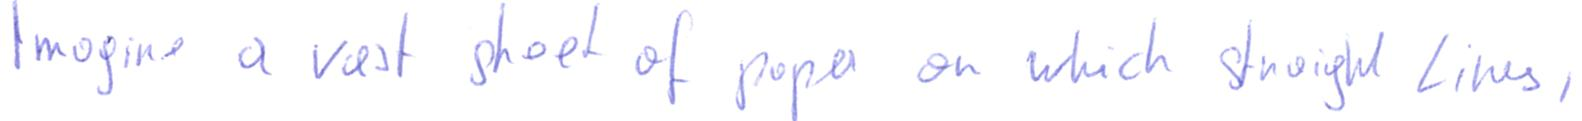

In [189]:
# The sample image
images[0]

In [190]:
pixel_values = processor(images=[images[0]], return_tensors="pt").pixel_values
encoded_image = model.encoder(pixel_values.to(device))
encoded_image.last_hidden_state.shape

torch.Size([1, 577, 768])

Consistent with what we found previously, the image is encoded into 577 tokens of dimensionality 768. Let's pass these to the decoder:

In [191]:
decoded = model.decoder.forward(
    input_ids=torch.Tensor([[0]]).to(device, dtype=int),
    encoder_hidden_states=encoded_image['last_hidden_state'],
)
print(decoded.logits.shape)
decoded.logits.argmax()

torch.Size([1, 1, 50265])


tensor(31206, device='cuda:0')

The decoder gives probabilities for all 50265 potential string tokens in the tokenizer's vocabulary. The most likely token has the number 31206. What does this correspond to? The `processor` can translate between token numbers and strings. Let's give it a whirl:

In [192]:
processor.tokenizer.decode(31206)

'Imagine'

It's the first word in the sentence! We can keep feeding the outputs of the decoder to itself to build a string decoding.

In [193]:
decoded = model.decoder.forward(
    input_ids=torch.Tensor([[0, 31206]]).to(device, dtype=int),
    encoder_hidden_states=encoded_image['last_hidden_state'],
)
processor.tokenizer.decode(decoded.logits[:, -1, :].argmax().item())

' a'

Continuing this process allows us to transcribe the entire image. Greedily choosing the most likely word can lead to suboptimal decoding, however. A common technique to improve this is to keep multiple likely decodings in memory, pruning as we process more of the sequence, only deciding the very best sequence at the end. This is known as a beam search. `model.generate` uses a beam search to get the best transcription.

In [194]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)

# move it to the same device
pixel_values = pixel_values.to(device)

# Generate the sequence using the model
best_sequence = model.generate(pixel_values)

# Decode the generated sequence
decoded_sequence = processor.tokenizer.decode(best_sequence[0])
print(decoded_sequence)

</s>Imagine a vast sheet of paper on which straight lines,</s>


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Decoder")

## Interactive exploration 3.2: What the model pays attention to

We've just seen that these are two relatively large-scale transformers that are wired in the conventional encoder-decoder architecture. The transformers themselves are generic and have relatively weak built-in inductive biases. Has the model learned to process the sequence reasonably?

One tool at our disposal to address this question is to look at the **attention pattern** in the decoding heads as we process an image. By looking at the output of the cross-attention heads, we can gain an intuitive understanding of what the model "looks at."

Let's look at how the model's attention evolves as we process more and more of the sequence.

In [ ]:
decoded = model.decoder.forward(
    input_ids=best_sequence,
    encoder_hidden_states=encoded_image['last_hidden_state'],
    output_attentions=True
)

In [185]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

def visualize_attention(layer, head):
    plt.figure(figsize=(10, 10))

    image = images[0]
    for token in range(decoded.cross_attentions[layer].shape[2]):
        attention_pattern = decoded.cross_attentions[layer][0, head, token, 1:].reshape((24, 24))
        attention_pattern = attention_pattern.detach().cpu().numpy()

        print(processor.decode(best_sequence[0][:token+1]))
        plt.imshow((np.array(image).mean(axis=2)).astype(float), cmap='gray')
        plt.imshow(attention_pattern, extent=[0, image.width, 0, image.height], alpha=attention_pattern/attention_pattern.max(), cmap='YlOrRd')
        plt.axis('off')
        plt.gca().invert_yaxis()
        plt.show()


# Create interactive widgets
layer_slider = widgets.IntSlider(min=0, max=len(decoded.cross_attentions)-1, step=1, value=7, description='Layer')
head_slider = widgets.IntSlider(min=0, max=decoded.cross_attentions[0].shape[1]-1, step=1, value=5, description='Head')

# Create the interactive visualization
interact(visualize_attention, layer=layer_slider, head=head_slider)

interactive(children=(IntSlider(value=7, description='Layer', max=11), IntSlider(value=5, description='Head', …

<function __main__.visualize_attention(layer, head)>

You'll notice that attention heads in intermediate layers seem to track the likely location of the next word in the input image, left to right. It is remarkable that the model has learned an important aspect of the spatial structure of sentences written in the Latin alphabet, which is that words are written left-to-right and that words have a certain characteristic width.

**Positional encoding** allows the model to express spatial biases; without it, the model would be position invariant. However, nothing in the model **predetermines** that text must be left to right: it learns that structure through data. The model follows the standard recipe of modern AI: take a model with weak inductive biases that scales well, and train it on large-scale data to distill structure.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Interactive_Exploration_3.2")

In [ ]:
# @title Video 4: Weak Inductive Biases

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '4BTM5Mrb94Y'), ('Bilibili', 'BV1jw4m1v7g6')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_weak_inductive_biases")

---
# Section 4: The magic in the data

It's straightforward to write down the encoder-decoder transformer used by TrOCR–it's conceptually quite similar to the original transformer as outlined in Vaswani et al. (2017). What makes the model tick (and potentially break) is a training pipeline that ensures good generalization. It's worth taking a look at the TrOCR paper to see the many different sources of data that are used to train the model:

1. [The encoder is pretrained on masked image modeling on ImageNet-22k](https://huggingface.co/docs/transformers/en/model_doc/beit)
2. [The decoder is pretrained on masked language modeling on 160GB of raw text](https://arxiv.org/abs/1907.11692)
3. The entire model is trained end-to-end on 648M text lines found in 2M PDF pages on the internet, with the fonts randomly swapped
4. The model is then fine-tuned end-to-end on the IAM handwriting dataset, with heavy augmentation

Let's look at a few of these pieces in turn.

## Section 4.1: Transfer learning

Modern neural networks are often pre-trained on large datasets. For example, the TrOCR model's decoder is pretrained on masked language modeling on 160GB of raw text. The frozen weights are used as initialization for the model, a form of transfer learning. The same principle applies to the encoder, which is pretrained on masked image modeling on ImageNet-22k. Although these tasks are quite different from the final task of handwriting recognition, the model learns useful features that can be transferred to the final task.

The datasets involved in pre-training are often large: 160GB of raw text would take a human close to 1000 lifetimes to write! Yet, this is quite small by modern standards: [FineWeb](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1?utm_source=ainews&utm_medium=email&utm_campaign=ainews-mamba-2-state-space-duality) is almost a thousand times larger. It's an incredible feat of engineering that we can build models that learn effective representations from such large scale data. The "bitter lesson" of AI is that models trained on more data tend to perform better, and generalize better.

### Reflection

What happens when we've trained on all the data we can find? What are other ways to improve generalization in conventional large-scale AI?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_transfer_learning")

## Section 4.2: Generalization via augmentation

Another important ingredient in this model is the use of multiple augmentations of the data. When data is sparse, this can improve generalization. Thus, we take an expressive model with few built-in inductive biases and, through demonstrations, let it learn the structure of the data, encouraging generalization.

By applying various transformations to images and displaying the results, you can visually understand how augmentation works and its impact on model performance. Let's look at parts of the TrOCR recipe.

Let's start with loading and visualizing our chosen image.

![Picture which shows neuroai_hello_world.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/neuroai_hello_world.png?raw=true)

Now, we will apply a few transformations to this image. You can play around with the input values!

In [ ]:
# Convert PIL Image to Tensor
image = IMG.open("neuroai_hello_world.png")
image = transforms.ToTensor()(image)

# Define each transformation separately
# RandomAffine: applies rotations, translations, scaling. Here, rotates by up to ±15 degrees,
affine = transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1))

# ElasticTransform: applies elastic distortions to the image. The 'alpha' parameter controls
# the intensity of the distortion.
elastic = transforms.ElasticTransform(alpha=25.0)

# RandomPerspective: applies random perspective transformations with a specified distortion scale.
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)

# RandomErasing: randomly erases a rectangle area in the image.
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)

# GaussianBlur: applies gaussian blur with specified kernel size and sigma range.
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.8, 5))

Let's now combine them in a single list and display the images.

In [ ]:
# A list of all transformations for iteration
transformations = [affine, elastic, perspective, erasing, gaussian_blur]

# Display
display_transformed_images(image, transformations)

The transformations applied to the model include:

1. Original: the baseline image without any modifications.
2. RandomAffine: applies random affine transformations to the image, which include translation, scaling, rotation, and shearing. This helps the model become invariant to such transformations in the input data.
3. ElasticTransform: introduces random elastic deformations, simulating non-linear transformations that might occur naturally. It is useful for tasks where we expect such distortions, like medical image analysis.
4. RandomPerspective: changes the perspective from which the image is viewed, simulating the effect of viewing the object from different angles.
5. RandomErasing: randomly removes parts of the image and fills it with some arbitrary pixel values. It can make the model robust against occlusions in the input data.
6. GaussianBlur: applies a Gaussian blur to the image, smoothing it. This can help the model be better with out-of-focus images.

All of these augmentations, which are part of this model's training recipe, help prevent overfitting and improve the generalization of the model to new, unseen images. We can compose these to create new challenging training images:

In [ ]:
# Combine all the transformations
all_transforms = transforms.Compose([
    affine,
    elastic,
    perspective,
    erasing,
    gaussian_blur
])

# Apply combined transformation
augmented_image_tensor = all_transforms(image)

display_original_and_transformed_images(image, augmented_image_tensor)

All those transformation create a challenging curriculum that forces the model to generalize. Note that we're limited by our imagination in creating these augmentations. Some real world invariances, for example invariance to the style of handwritten characters, can be hard to simulate with this approach.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Augmentation")

## Section 4.3: Generalization via synthetic data

When augmentation is not enough, we can further improve generalization by training on synthetic data. **Data augmentation** creates variations of existing data without changing its inherent properties, while **synthetic data** generation creates entirely new data that mimics the characteristics of real data.

As it turns out, generating new text is tractable–text can be rendered in a wide range of cursive fonts to simulate real data. Here, we'll showcase this idea by defining strings and generating synthetic images.

In [ ]:
# Define strings
strings = ['Hello world', 'This is the first tutorial', 'For Neuromatch NeuroAI']

# Specify font path
font_path = "DancingScript-VariableFont_wght.ttf"  # Ensure this path is correct

# Example usage
strings = ['Hello world', 'This is the first tutorial', 'For Neuromatch NeuroAI']
font_path = "DancingScript-VariableFont_wght.ttf"  # Ensure this path is correct

# Create a generator with the specified parameters
generator = image_generator(strings, font_path, space_width=2, skewing_angle=3)

i = 1
for img in generator:
  plt.imshow(img, cmap='gray')
  plt.title(f"Example {i}")
  plt.axis('off')
  plt.show()
  i += 1

### Discussion point

What does this type of synthetic data capture that wouldn’t be easy to capture through data augmentation?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Synthetic_Data")

### Interactive demo 4.1: Generating handwriting style data

We can take this idea further and generate handwriting-style data. We will use an embedded `calligrapher.ai` model to generate new snippets of writing data. This generator is based off of a recurrent neural network trained on the same corpus of handwritten data as the TrOCR model, the IAM dataset.

In [ ]:
IFrame("https://www.calligrapher.ai/", width=800, height=600)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Generate_Handwriting")

# Conclusion

We train models to minimize a loss function. Oftentimes, however, what we care about is something different, like how well the model will generalize when it's deployed. Our intrepid developer got a rude awakening when comparing the OOD robustness of the model to its empirical loss on the train set: the character error rate was several times larger than expected. Motivated by other factors, like engineering complexity, our developer decided to move forward and deploy a handwriting transcription system, hoping it could be fine-tuned based on users' data later.

There's a lot that goes into the training of robust AI models that generalize well. Generic high-capacity models with weak inductive biases, like transformers, are trained on large-scale data. Pretraining, augmentations, and synthetic data can all be part of the recipe for learning structure that might be hard to express mathematically, such as the fact that text is written left to right. Because large-scale models can often require a significant amount of computation to train, in practice, models that have been trained for other purposes are adapted and re-used, preventing the need to learn from scratch. These models embody what's known as ["the bitter lesson"](http://www.incompleteideas.net/IncIdeas/BitterLesson.html): general methods that leverage computation are ultimately the most effective, and by a large margin.

In [ ]:
# @title Video 5: Final Thoughts

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'fxgIYvbU1Pg'), ('Bilibili', 'BV1ci421e7mq')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_final_thoughts")

---
# Summary

* Artificial intelligence practitioners aim to maximize the performance of their systems under engineering constraints of size, weight, power, cost, latency, and maintenance.
* In-distribution performance doesn't tell the whole story: out-of-distribution robustness can be measured to determine how well a model will perform when deployed in the real world.
* Generic models with weak inductive biases, like transformers, can learn structure from large-scale data.
* Several strategies can be used to build models that display better generalization, all of which hinge on distilling structure from ever larger amounts of data:
  * Transfer learning
  * Augmentations
  * Synthetic examples